## loading data and libraries

In [137]:
import pandas as pd 
import numpy as nm
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [138]:
sales =  pd.read_csv('./data/phppos_sales.csv')
sales_items =  pd.read_csv('./data/phppos_sales_items.csv')

In [139]:
all_sales = pd.merge(sales_items , sales , on = 'sale_id')

In [140]:
all_sales

sale_id  item_id  quantity_purchased  item_cost_price  \
0             1        1                   3            94.00   
1             1        2                   2           109.00   
2             2        1                   5            94.00   
3             2        2                   1           109.00   
4             3        1                   1            94.00   
...         ...      ...                 ...              ...   
120170    81421     1431                   1             9.00   
120171    81422      973                   1             3.60   
120172    81423     1433                   1             4.00   
120173    81428       41                   4             4.05   
120174    81428     1402                   1            14.00   

        item_unit_price  discount_percent            sale_time  customer_id  \
0                 130.0                 0  2005-10-12 22:47:28          NaN   
1                 120.0                 0  2005-10-12 22:47:28          NaN   
2                 130.0                 0  2005-10-12 22:54:00          NaN   
3                 120.0                 0  2005-10-12 22:54:00          NaN   
4                 130.0                 0  2020-07-05 12:42:15          NaN   
...                 ...               ...                  ...          ...   
120170             10.0                 0  2022-02-12 18:06:47          NaN   
120171              5.0                 0  2022-02-12 18:11:13          NaN   
120172              5.0                 0  2022-02-12 18:16:18          NaN   
120173              7.5                 0  2022-02-12 18:28:03          NaN   
120174             20.0                 0  2022-02-12 18:28:03          NaN   

        employee_id comment payment_type  
0                 1     NaN         Cash  
1                 1     NaN         Cash  
2                 2     NaN         Cash  
3                 2     NaN         Cash  
4                 1     NaN         Cash  
...             ...     ...          ...  
120170            1     NaN         Cash  
120171            1     NaN         Cash  
120172            1     NaN        MPESA  
120173            1     NaN         Cash  
120174            1     NaN         Cash  

[120175 rows x 11 columns]

## data cleaning

minimart was opened on 2020 thus data from 2005 was wrongly filled

In [141]:
all_sales.sale_time = pd.to_datetime(all_sales.sale_time,format = '%Y-%m-%d %H:%M')

In [142]:
all_sales = all_sales[all_sales.sale_time > "2005-12-31"]

In [143]:
all_sales.dtypes

sale_id                        int64
item_id                        int64
quantity_purchased             int64
item_cost_price              float64
item_unit_price              float64
discount_percent               int64
sale_time             datetime64[ns]
customer_id                  float64
employee_id                    int64
comment                       object
payment_type                  object
dtype: object

drop irrelevant colomns of the data set

In [144]:
all_sales = all_sales.drop(['discount_percent','comment','customer_id','employee_id'],axis = 1 )

In [145]:
all_sales[all_sales.quantity_purchased < 0]

sale_id  item_id  quantity_purchased  item_cost_price  \
16            9        1                  -1            94.00   
553         427      112                  -1           100.00   
575         445       97                  -1            45.00   
751         592       97                  -2            45.00   
784         621       48                  -1            33.50   
...         ...      ...                 ...              ...   
118287    80083        4                  -2           114.20   
118490    80236      480                  -1            32.00   
119550    80982     1006                  -1           541.66   
119914    81235      289                -500             0.90   
120043    81332     1019                  -1            75.00   

        item_unit_price           sale_time payment_type  
16                130.0 2020-07-05 13:14:09         Cash  
553               150.0 2020-07-21 17:06:00         Cash  
575               100.0 2020-07-22 15:55:31         Cash  
751               100.0 2020-08-13 07:56:57         Cash  
784                50.0 2020-08-13 17:34:06         Cash  
...                 ...                 ...          ...  
118287            120.0 2022-01-27 17:35:31         Cash  
118490             50.0 2022-01-30 13:28:42         Cash  
119550            580.0 2022-02-08 17:56:50         Cash  
119914              1.0 2022-02-11 15:01:43         Cash  
120043             80.0 2022-02-12 11:17:05         Cash  

[573 rows x 7 columns]

573 items were returned

In [146]:

# item cost price is reater tan item sellin price
n_price = all_sales[all_sales.item_cost_price > all_sales.item_unit_price]


# item cost price is less tan item sellin price
t_price = all_sales[all_sales.item_cost_price < all_sales.item_unit_price]

In [147]:
n_price.groupby('item_id')['quantity_purchased'].count()

item_id
94      53
95      50
214      1
284     17
392     13
399     11
438      2
466      1
546      1
608      1
609      1
817      7
834     11
876      3
1006     3
1074     1
1110    11
Name: quantity_purchased, dtype: int64

14 items were  item unit and cost price was wonly entered in the system 

3 items unit cost price were wronly entered

In [148]:
n_price[n_price.item_id == 1110]

sale_id  item_id  quantity_purchased  item_cost_price  \
41774     27742     1110                   1            288.0   
42186     28004     1110                   1            288.0   
47228     31126     1110                   1            288.0   
50652     33270     1110                   1            288.0   
59155     38874     1110                   1            288.0   
63923     41991     1110                   1            288.0   
80264     52934     1110                   1            288.0   
88297     58463     1110                   1            288.0   
88933     58898     1110                   1            288.0   
107085    71973     1110                   1            288.0   
117665    79628     1110                   1            288.0   

        item_unit_price           sale_time payment_type  
41774             223.0 2021-01-31 12:17:14         Cash  
42186             223.0 2021-02-01 14:46:24        MPESA  
47228             223.0 2021-02-16 17:40:55        MPESA  
50652             223.0 2021-02-27 14:53:30         Cash  
59155             223.0 2021-03-25 17:46:18        MPESA  
63923             223.0 2021-04-12 14:48:18        MPESA  
80264             223.0 2021-06-07 14:15:05        MPESA  
88297             223.0 2021-07-09 16:47:01         Cash  
88933             223.0 2021-07-12 16:03:39         Cash  
107085            223.0 2021-10-22 02:56:14        MPESA  
117665            223.0 2022-01-21 09:25:13         Cash

In [149]:
i834 = n_price[n_price.item_id == 834]
n_i834 = n_price[n_price.item_id != 834]

In [150]:
i834.item_cost_price = 45.0

C:\Users\mickn\AppData\Local\Temp\ipykernel_16752\2792711725.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i834.item_cost_price = 45.0


In [151]:
n_price = pd.concat([n_i834,i834])

In [152]:
all_sales

sale_id  item_id  quantity_purchased  item_cost_price  \
4             3        1                   1            94.00   
5             3        2                   1           109.00   
6             4        1                   3            94.00   
7             4        2                   2           109.00   
8             5        1                   1            94.00   
...         ...      ...                 ...              ...   
120170    81421     1431                   1             9.00   
120171    81422      973                   1             3.60   
120172    81423     1433                   1             4.00   
120173    81428       41                   4             4.05   
120174    81428     1402                   1            14.00   

        item_unit_price           sale_time payment_type  
4                 130.0 2020-07-05 12:42:15         Cash  
5                 120.0 2020-07-05 12:42:15         Cash  
6                 130.0 2020-07-05 12:52:46         Cash  
7                 120.0 2020-07-05 12:52:46         Cash  
8                 130.0 2020-07-05 12:54:43         Cash  
...                 ...                 ...          ...  
120170             10.0 2022-02-12 18:06:47         Cash  
120171              5.0 2022-02-12 18:11:13         Cash  
120172              5.0 2022-02-12 18:16:18        MPESA  
120173              7.5 2022-02-12 18:28:03         Cash  
120174             20.0 2022-02-12 18:28:03         Cash  

[120139 rows x 7 columns]

In [153]:
i438 = n_price[n_price.item_id == 438]
n_i438 = n_price[n_price.item_id != 438]

In [154]:
i438.item_cost_price = 35.0

C:\Users\mickn\AppData\Local\Temp\ipykernel_16752\2257334176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i438.item_cost_price = 35.0


In [155]:
n_price = pd.concat([n_i438,i438])

In [156]:
i1006 = n_price[n_price.item_id == 1006]
n_i1006 = n_price[n_price.item_id != 1006]

In [157]:
i1006.item_cost_price.replace(55000.0 , 550.0 , inplace=True)

C:\Users\mickn\AppData\Local\Temp\ipykernel_16752\2669379045.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i1006.item_cost_price.replace(55000.0 , 550.0 , inplace=True)


In [158]:
n_price = pd.concat([n_i1006,i1006])

In [159]:
r_n_price = n_price[n_price.item_cost_price > n_price.item_unit_price]
n_price = n_price[n_price.item_cost_price < n_price.item_unit_price]

In [160]:
a_price = r_n_price.copy()

In [161]:
r_n_price.item_cost_price = a_price.item_unit_price
r_n_price.item_unit_price = a_price.item_cost_price

In [162]:
n_price = pd.concat([n_price, r_n_price])

In [163]:
all_sales = pd.concat([t_price , n_price])

In [164]:
all_sales.drop_duplicates()

sale_id  item_id  quantity_purchased  item_cost_price  \
4             3        1                   1             94.0   
5             3        2                   1            109.0   
6             4        1                   3             94.0   
7             4        2                   2            109.0   
8             5        1                   1             94.0   
...         ...      ...                 ...              ...   
88297     58463     1110                   1            223.0   
88933     58898     1110                   1            223.0   
107085    71973     1110                   1            223.0   
117665    79628     1110                   1            223.0   
118937    80566     1074                   1            265.0   

        item_unit_price           sale_time payment_type  
4                 130.0 2020-07-05 12:42:15         Cash  
5                 120.0 2020-07-05 12:42:15         Cash  
6                 130.0 2020-07-05 12:52:46         Cash  
7                 120.0 2020-07-05 12:52:46         Cash  
8                 130.0 2020-07-05 12:54:43         Cash  
...                 ...                 ...          ...  
88297             288.0 2021-07-09 16:47:01         Cash  
88933             288.0 2021-07-12 16:03:39         Cash  
107085            288.0 2021-10-22 02:56:14        MPESA  
117665            288.0 2022-01-21 09:25:13         Cash  
118937            297.0 2022-02-03 16:51:17         Cash  

[120087 rows x 7 columns]

In [165]:
all_sales.to_csv('pos_sales.csv' , index = False)

## Feature engineering

In [166]:
pos_sales = pd.read_csv('pos_sales.csv')

In [167]:
pos_sales['total_buyin_p'] = pos_sales.quantity_purchased * pos_sales.item_cost_price
pos_sales['total_sellin_p'] = pos_sales.quantity_purchased * pos_sales.item_unit_price
pos_sales['profit'] = pos_sales.total_sellin_p - pos_sales.total_buyin_p

In [168]:
pos_sales.sale_time = pd.to_datetime(pos_sales.sale_time,format = '%Y-%m-%d %H:%M')

In [169]:
pos_sales['year'] = pos_sales['sale_time'].dt.year
pos_sales['month'] = pos_sales['sale_time'].dt.month

pos_sales['day'] = pos_sales['sale_time'].dt.day
pos_sales['dayofweek'] = pos_sales['sale_time'].dt.dayofweek
pos_sales['hour'] = pos_sales['sale_time'].dt.hour

In [170]:
pos_sales.payment_type.replace('Cash' , 0 , inplace=True)
pos_sales.payment_type.replace('MPESA' , 1 , inplace=True)

In [171]:
pos_sales = pos_sales.drop(['sale_time','sale_id'],axis = 1)

In [172]:
pos_sales.to_csv('pos_sales.csv' , index = False)


## Analysis

daily analysis

<AxesSubplot:xlabel='dayofweek'>

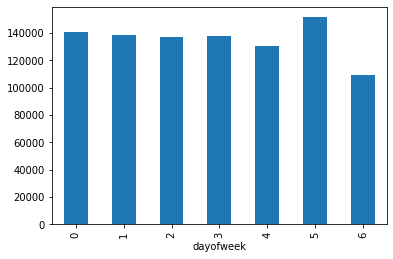

In [173]:
pos_sales.groupby('dayofweek')['profit'].sum().plot.bar()

<AxesSubplot:xlabel='dayofweek'>

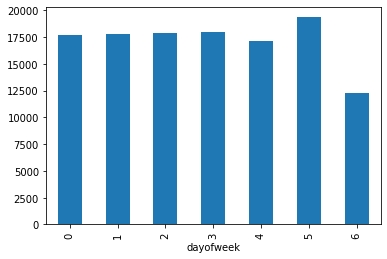

In [174]:
pos_sales.groupby('dayofweek')['quantity_purchased'].count().plot.bar()


monthly analysis

<AxesSubplot:xlabel='month'>

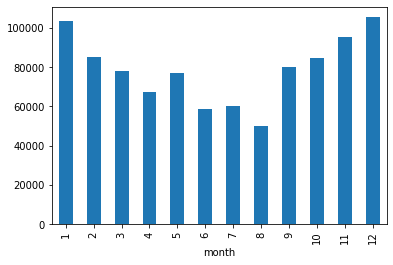

In [175]:
pos_sales.groupby('month')['profit'].sum().plot.bar()

<AxesSubplot:xlabel='month'>

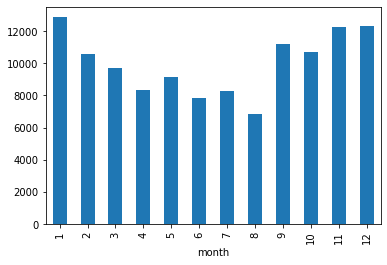

In [176]:
pos_sales.groupby('month')['quantity_purchased'].count().plot.bar()

yearly analysis

<AxesSubplot:xlabel='month,dayofweek'>

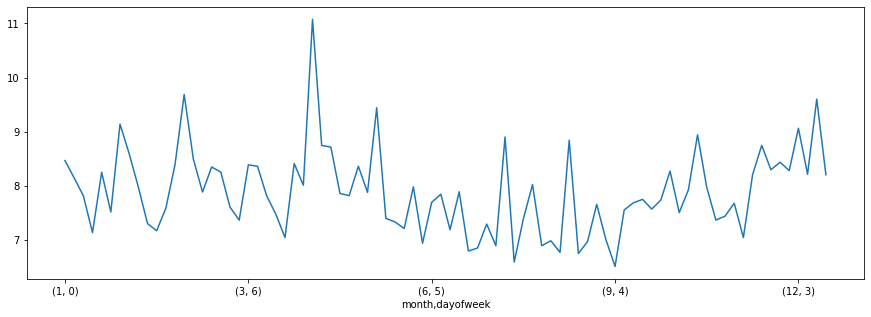

In [177]:
pos_sales.groupby(['month','dayofweek'])['profit'].mean().plot(figsize= (15,5))

<AxesSubplot:xlabel='month,day'>

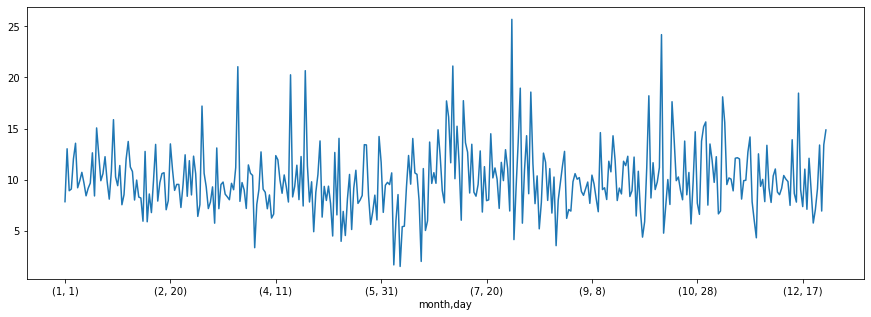

In [178]:
pos_sales.groupby(['month','day'])['quantity_purchased'].mean().plot(figsize= (15 , 5))

item analysis

In [179]:
pos_sales.groupby('item_id')['quantity_purchased'].count().to_frame()

quantity_purchased
item_id                    
1                        39
2                        37
3                       375
4                      1831
5                       161
...                     ...
1427                      1
1428                      1
1429                      1
1431                      1
1433                      1

[1221 rows x 1 columns]

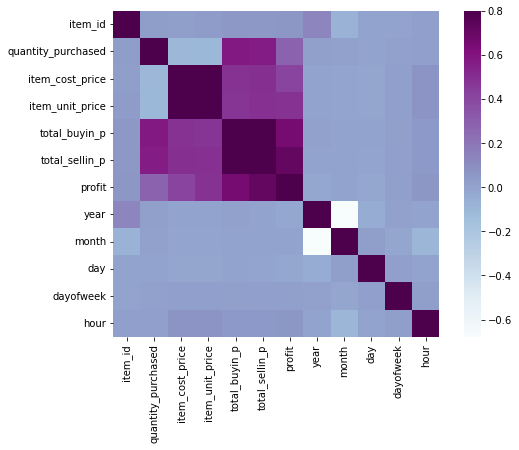

In [180]:
matrix = pos_sales.corr() 
ax = plt.subplots(figsize=(9,6))
sns.heatmap(matrix , vmax = .8, square= True , cmap = 'BuPu');

## model

split data

In [181]:
test = pos_sales[(pos_sales.year >= 2020) > (pos_sales.year > 2021)]
train = pos_sales[(pos_sales.year > 2021) > (pos_sales.year > 2022)]

y= train.profit
x = train

x = pd.get_dummies(x)
train = pd.get_dummies(train)
test = pd.get_dummies(test)

i = 1 
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(x , y):
    print('{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = x.iloc[train_index],x.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print('accuracy_score',score)
    i+=1
    pred_test = model.predict(test)
    pred = model.predict_proba(xvl)[:, 1]

C:\Users\mickn\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)
C:\Users\mickn\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.